# Template - Strategy - Backtesting 

### Import Library

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy
# from backtesting._plotting import set_bokeh_output
# set_bokeh_output(notebook=False)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

/home/zuongthao/PycharmProjects/algo-stock/venv/lib/python3.11/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

### Load Price Data

In [2]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

remote


In [3]:
data = dataset.copy()

In [4]:
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
data = data[data.index > '2020-11-01 00:00:00']

In [5]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-02-13 14:15:00,1333.5,1335.4,1333.4,1335.0,5583
2025-02-13 14:20:00,1335.4,1336.5,1334.7,1334.9,5753
2025-02-13 14:25:00,1335.3,1336.8,1334.9,1336.8,4879


In [6]:
def prepare_data(htd):
    data_tmp = htd.copy()
    data_tmp['first_close'] = data_tmp.Close
    data_tmp['Close_price'] = data_tmp.Close
    data_tmp['_last'] = data_tmp.Close
    data_tmp['prev_high'] = data_tmp.High
    data_tmp['prev_low'] = data_tmp.Low
    day_data = data_tmp.resample("D").agg({
        'first_close': cal_first_close,
        'prev_high': cal_high_before,
        'prev_low': cal_low_before,
        '_last': cal_last
    }).rename(columns={'_last': 'day_Close'})
    day_data.dropna(subset=['first_close'], inplace=True)
    day_data['prev_day_Close'] = day_data['day_Close'].shift(1)
    day_data.drop(columns=['day_Close'], inplace=True)
    day_data = day_data.dropna()

    data = htd.assign(time_d=pd.PeriodIndex(htd.index, freq='1D').to_timestamp())
    data = pd.merge(data, day_data, left_on="time_d", right_index=True, how="left")
    data.dropna(inplace=True)

    data["current"] = data.index + pd.DateOffset(minutes=5)
    data['mom_y'] = 100 * (data.Close - data.prev_day_Close) / data.prev_day_Close
    data['body_rate'] = (data.Close - data.first_close) / (data.prev_high - data.prev_low)
    adx = ta.adx(data['High'], data['Low'], data['Close'], length = 42)
    data = data.assign(ADX=adx['ADX_42'])
    data['signal'] = data.apply(lambda r: cal_signal(r), axis=1)
    data['signal_shift'] = data['signal'].shift(1)
    data.dropna(inplace=True)
    data['ADX'] = round(data['ADX'])
    return data[['Open', 'Close', 'High', 'Low', 'Volume', 'signal', 'ADX', 'current']]


def cal_signal(row):
    signal = ''
    if row['Close'] - row['prev_low'] > 21 or row['prev_high'] - row['Close'] > 21:
        return signal
    if row['mom_y'] > 0.26 and row['body_rate'] > .65 and row['ADX'] < 26.5:
        signal = 'long'
    elif row['mom_y'] < -.18 and row['body_rate'] < -.39 and row['ADX'] < 26.5:
        signal = 'short'
    return signal


def cal_first_close(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute == 915]
    if not tick.empty:
        return tick[0]


def cal_high_before(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute < 1345]
    return tick.max()


def cal_low_before(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute < 1355]
    return tick.min()


def cal_last(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute == 1445]
    if not tick.empty:
        return tick[0]

In [7]:
class Momentum(Strategy):
    max_risk = 5.5
    tp_step = 20
    def init(self):
        self._broker._cash = 1500
        super().init()

    def next(self):
        super().next()
        _time = self.data.index
        current_time = _time[-1]
        if current_time.hour == 14 and current_time.minute >= 25:
            if self.position.is_long or self.position.is_short:
                self.position.close()
                return

        if current_time.hour == 13 and current_time.minute == 55:
            close_price = self.data.Close[-1]
            signal = self.data.signal[-1]
            if signal == 'long':
                buy_price = close_price
                sl = buy_price - self.max_risk
                tp = buy_price + self.tp_step
                self.buy(size=1, sl=sl, tp=tp)
            elif signal == 'short':
                sell_price = close_price
                sl = sell_price + self.max_risk
                tp = sell_price - self.tp_step
                self.sell(size=1, sl=sl, tp=tp)

In [8]:
prepared_data = prepare_data(data)
prepared_data.dropna(inplace=True)

In [9]:
prepared_data

,Open,Close,High,Low,Volume,signal,ADX,current
Date,,,,,,,,
2020-11-04 13:05:00,912.6,912.8,913.3,912.1,2847,,13.0,2020-11-04 13:10:00
2020-11-04 13:10:00,912.6,912.9,913.4,912.3,1396,,13.0,2020-11-04 13:15:00
2020-11-04 13:15:00,912.9,912.6,913.1,912.1,1892,,13.0,2020-11-04 13:20:00
2020-11-04 13:20:00,912.6,912.8,913.2,912.2,2107,,13.0,2020-11-04 13:25:00
2020-11-04 13:25:00,912.8,914.2,914.4,912.7,3460,long,14.0,2020-11-04 13:30:00
...,...,...,...,...,...,...,...,...
2025-02-13 14:15:00,1333.5,1335.0,1335.4,1333.4,5583,,14.0,2025-02-13 14:20:00
2025-02-13 14:20:00,1335.4,1334.9,1336.5,1334.7,5753,,14.0,2025-02-13 14:25:00
2025-02-13 14:25:00,1335.3,1336.8,1336.8,1334.9,4879,,14.0,2025-02-13 14:30:00


In [10]:
bt = Backtest(prepared_data, Momentum, commission=.0003, exclusive_orders=True)
stats = bt.run()
# bt.plot()
print(stats)

Start                     2020-11-04 13:05:00
End                       2025-02-13 14:45:00
Duration                   1562 days 01:40:00
Exposure Time [%]                    2.893707
Equity Final [$]                   1881.65003
Equity Peak [$]                    1891.47264
Return [%]                          25.443335
Buy & Hold Return [%]               46.527169
Return (Ann.) [%]                    5.622462
Volatility (Ann.) [%]                3.097781
Sharpe Ratio                         1.814997
Sortino Ratio                        4.092119
Calmar Ratio                         2.745239
Max. Drawdown [%]                   -2.048077
Avg. Drawdown [%]                   -0.340452
Max. Drawdown Duration      167 days 00:10:00
Avg. Drawdown Duration       13 days 23:34:00
# Trades                                  252
Win Rate [%]                        58.730159
Best Trade [%]                       1.749788
Worst Trade [%]                     -0.662575
Avg. Trade [%]                    

In [11]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
0,1,11,15,916.87498,910.8,-6.07498,-0.006626,2020-11-04 14:00:00,2020-11-04 14:20:00,None,0 days 00:20:00
1,-1,113,119,907.02781,910.5,-3.47219,-0.003828,2020-11-06 14:00:00,2020-11-06 14:30:00,None,0 days 00:30:00
2,-1,266,271,915.32532,921.1,-5.77468,-0.006309,2020-11-11 14:00:00,2020-11-11 14:25:00,None,0 days 00:25:00
3,1,366,372,933.17987,935.8,2.62013,0.002808,2020-11-13 14:00:00,2020-11-13 14:30:00,None,0 days 00:30:00
4,-1,417,423,933.11998,917.5,15.61998,0.016740,2020-11-16 14:00:00,2020-11-16 14:30:00,None,0 days 00:30:00
...,...,...,...,...,...,...,...,...,...,...,...
247,-1,53124,53130,1312.60610,1311.9,0.70610,0.000538,2025-01-09 14:00:00,2025-01-09 14:30:00,None,0 days 00:30:00
248,-1,53175,53181,1309.00718,1295.6,13.40718,0.010242,2025-01-10 14:00:00,2025-01-10 14:30:00,None,0 days 00:30:00
249,1,53430,53436,1315.69459,1318.9,3.20541,0.002436,2025-01-17 14:00:00,2025-01-17 14:30:00,None,0 days 00:30:00
250,-1,53532,53538,1318.70427,1321.3,-2.59573,-0.001968,2025-01-21 14:00:00,2025-01-21 14:30:00,None,0 days 00:30:00


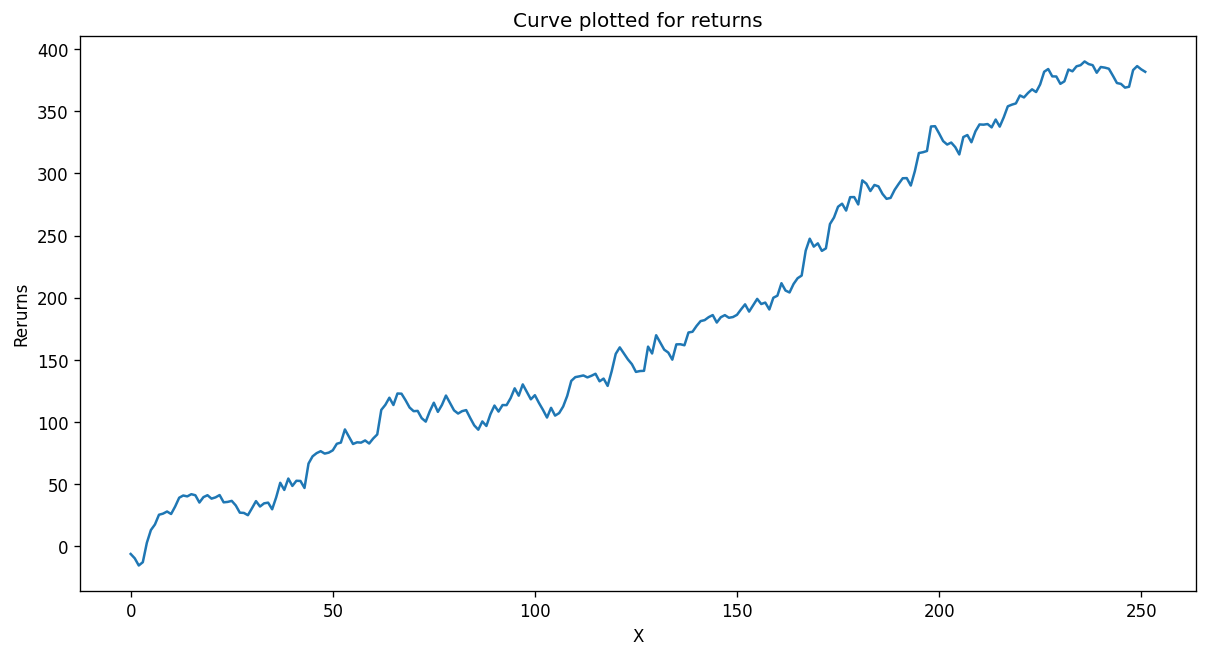

In [12]:
trades = stats['_trades']
copy_trades = trades.copy()
copy_trades['cum_sum'] = copy_trades['PnL'].cumsum()
X = np.array(range(0, len(copy_trades['cum_sum'])))
Y = copy_trades['cum_sum']
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()